In [1]:
import os
project_root = os.pardir
import sys
sys.path.append(project_root)

In [29]:
import src.general as gen
from src.data import make_dataset as dat
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
import networkx as nx
import collections as col
import numpy as np
from src.what_affects_death import *
import tqdm
%matplotlib inline

In [3]:
data_dir = os.path.join(project_root, 'data', 'raw', '16-12-2016-Mega')

In [4]:
year = 1997
profits_filename = 'profits_' + str(year) + '.csv'
sizes_filename = 'sizes_' + str(year) + '.csv'
profits_filepath = os.path.join(data_dir, 'profits', profits_filename)
sizes_filepath = os.path.join(data_dir, 'sizes', sizes_filename)

In [5]:
p = pd.read_csv(profits_filepath, index_col='firm_id')
s = pd.read_csv(sizes_filepath, index_col='firm_id')
df = p.merge(s, left_index=True, right_index=True, suffixes=('_profit', '_size'))

In [6]:
a = df[df['value_size'] <10]

In [8]:
#look at number (and associated probability) of firms dying after t years by
#(i) degree, (ii) sum of degrees of neighbours, (iii) average degree of neighbours
t = 10
year1 = 1996
year2 = year1 + t

In [9]:
graph = dat.MakeLFN('1996-1997')

Name: LFN with flows: 1996-1997.
Type: Graph
Number of nodes: 31661
Number of edges: 37233
Average degree:   2.3520


In [10]:
#get dead IDs
death_years = dat.StrFromYrs(year1, year2)
deaths_filepath = os.path.join(project_root, dat.deaths_filepath)
dead_ids = dat.GetDeadIds(input_filepath=deaths_filepath, death_years=death_years)
dead_in_LFN = set(dead_ids).intersection(set(graph.nodes()))

In [11]:
#get degrees of dead ids
dead_degrees = [graph.degree(node) for node in dead_in_LFN]

#get number of each dead degree
dead_degree_count = pd.Series(col.Counter(dead_degrees), name ='Dead Degree Counts')
LFN_degree_count = pd.Series(col.Counter(graph.degree().values()), name = 'LFN Degree Counts')
df = pd.concat([dead_degree_count, LFN_degree_count], axis=1).fillna(0).astype(int)

#get probability of dying given degree
df['Proportion Dead'] = df['Dead Degree Counts']/df['LFN Degree Counts']

In [12]:
#get sums of degrees of neighbours of dead firms
dead_sum_of_neighs = []
for node in dead_in_LFN:
    neighs = nx.neighbors(graph, node)
    dead_sum_of_neighs += [sum(graph.degree(neighs).values())]
    
dead_sum_count = col.Counter(dead_sum_of_neighs)

sum_of_neighs = []
#get sums of degrees of neighbours of all nodes
for node in graph.nodes():
    neighs = nx.neighbors(graph, node)
    sum_of_neighs += [sum(graph.degree(neighs).values())]
    
sum_count = col.Counter(sum_of_neighs)

#get proportion of dead for each sum of neighbour degrees
prop_sum_dict = dict()
for s in sum_count.keys():
    prop_sum_dict[s] = dead_sum_count[s]/float(sum_count[s])
    


In [30]:
all_degrees = graph.degree().values()
all_nsum_counted = sum_count
number_mc_runs = 1000
number_dead_in_LFN = len(dead_in_LFN)

results = dict()
for key in all_nsum_counted.keys():
    results[key]=[]
for i in tqdm.tqdm(range(number_mc_runs)):
    dead_nsum_mc = SelectNWithoutReplacement(all_degrees, number_dead_in_LFN)
    dead_nsum_counted_mc = col.Counter(dead_nsum_mc)
    for key in results.keys():
        results[key] += [dead_nsum_counted_mc[key]]

100%|██████████| 1000/1000 [00:30<00:00, 31.12it/s]


In [51]:
avgs = dict()
n = float(len(results[1]))
for key in results.keys():
    avgs[key] = sum(results[key])/n

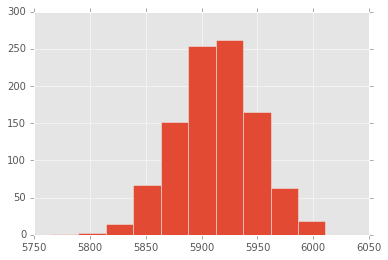

In [40]:
n, bins, info = plt.hist(results[1])
#plt.plot([dead_sum_count[1], dead_sum_count[1]], [0, max(n)], lw=100)

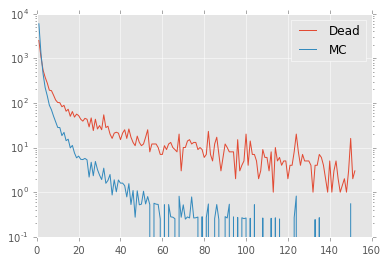

In [57]:
l = 150
plt.plot(dead_sum_count.keys()[:l], dead_sum_count.values()[:l], label='Dead')
plt.plot(avgs.keys()[:l], avgs.values()[:l], label='MC')
plt.yscale('log')
plt.legend()

In [60]:
avgs.values()[:10]

[5912.569,
 1260.275,
 445.559,
 219.797,
 144.375,
 88.661,
 70.025,
 50.518,
 38.021,
 28.159]

In [61]:
dead_sum_count.values()[:10]

[2503, 1069, 541, 374, 278, 192, 188, 149, 116, 102]